## Imprting Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

C:\Users\JShah\Anaconda3\envs\8387\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Reading Dataset

In [5]:
data=pd.read_csv('../data/processed/final_features.csv')
data.head()

,id,is_duplicate,common_word_ratio,fuzz_ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,0_x,1_x,2_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,325281,0,0.428571,66,80,64,100,-3.374177,75.931742,-49.858510,...,11.974018,-122.614036,-31.042748,56.335732,34.277889,-20.981779,-7.666217,23.235987,68.931672,77.785232
1,178566,0,0.666667,84,81,71,85,-5.394653,43.825213,-27.871097,...,45.185363,-82.663445,-30.306155,-35.358679,44.834592,-1.773371,-53.596881,32.928567,5.254334,9.394911
2,50007,1,0.428571,83,76,82,100,39.167425,29.544788,-29.630221,...,18.230023,-18.575513,-9.334889,-29.889852,-10.699831,-22.935040,-21.018854,-9.493121,50.324109,41.791082
3,129905,0,0.500000,62,77,73,75,3.972387,31.365034,-40.150880,...,24.162779,-23.402899,-30.708446,-24.155437,-11.419387,-22.274910,-61.421329,9.549272,26.779657,29.660736
4,166626,1,0.800000,87,100,87,100,-22.350316,75.609916,-41.066257,...,35.265637,-44.305794,-40.975855,-8.329676,-7.511494,21.513848,-18.739990,-13.070869,18.156852,14.612570


In [6]:
y_true=data['is_duplicate']
data.drop(['id','is_duplicate'], axis=1, inplace=True)

### Scaling

In [7]:
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(data)

### Train and Test split
Startify sampling is used. 

In [8]:
X_train,X_test, y_train, y_test = train_test_split(scaled, y_true, stratify=y_true, test_size=0.3, random_state = 42)

In [9]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (113107, 197)
Number of data points in test data : (48475, 197)


In [10]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",round(int(train_distr[0])/train_len, 2),"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.63 Class 1:  0.3686686058334144
---------- Distribution of output variable in test data ----------
Class 0:  0.6313357400722022 Class 1:  0.36866425992779783


## Some functions

* Function to plot confustion matrix
* Function create confustion matrix report
* Function to plot ROC curve

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    print ("-"*20," "*5, "ACCUARACY SCORE", " "*5, "-"*20)
    print(" "*10, "Accuracy score for model is : ", round(accuracy_score(test_y, predict_y),4))
    print ("-"*69)
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
    
def print_report(test_y, test_predict):
    from sklearn.metrics import confusion_matrix
    
    
    print(confusion_matrix(test_y, test_predict))

    from sklearn.metrics import classification_report
    print(classification_report(test_y, test_predict))
    
def plot_roc(test_y, test_probs):
    fpr, tpr, threshold = roc_curve(test_y, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.886703095094138
--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.4989
---------------------------------------------------------------------


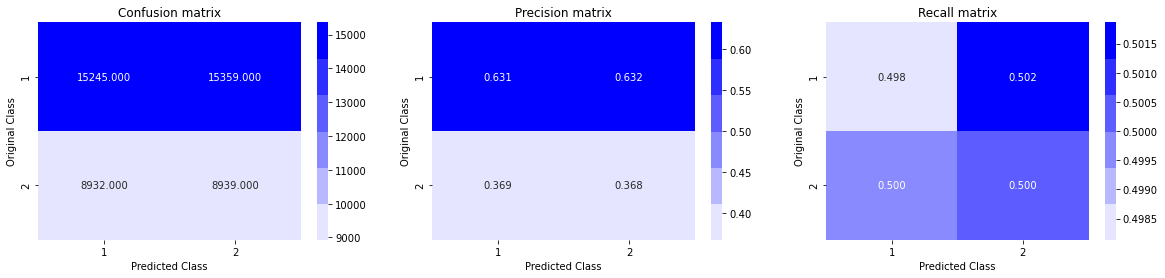

In [13]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [13]:
print_report(y_test, predicted_y)

[[15258 15346]
 [ 8939  8932]]
              precision    recall  f1-score   support

           0       0.63      0.50      0.56     30604
           1       0.37      0.50      0.42     17871

    accuracy                           0.50     48475
   macro avg       0.50      0.50      0.49     48475
weighted avg       0.53      0.50      0.51     48475



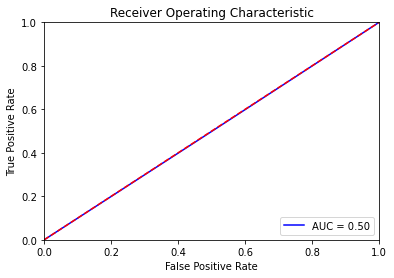

In [17]:
y_test_probs = plot_roc(y_test, predicted_y)

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5506911315200678
For values of alpha =  0.0001 The log loss is: 0.5437174355823792
For values of alpha =  0.001 The log loss is: 0.538760723157056
For values of alpha =  0.01 The log loss is: 0.5485874759892783
For values of alpha =  0.1 The log loss is: 0.5711389227043139
For values of alpha =  1 The log loss is: 0.658240948375401
For values of alpha =  10 The log loss is: 0.6582409483754011


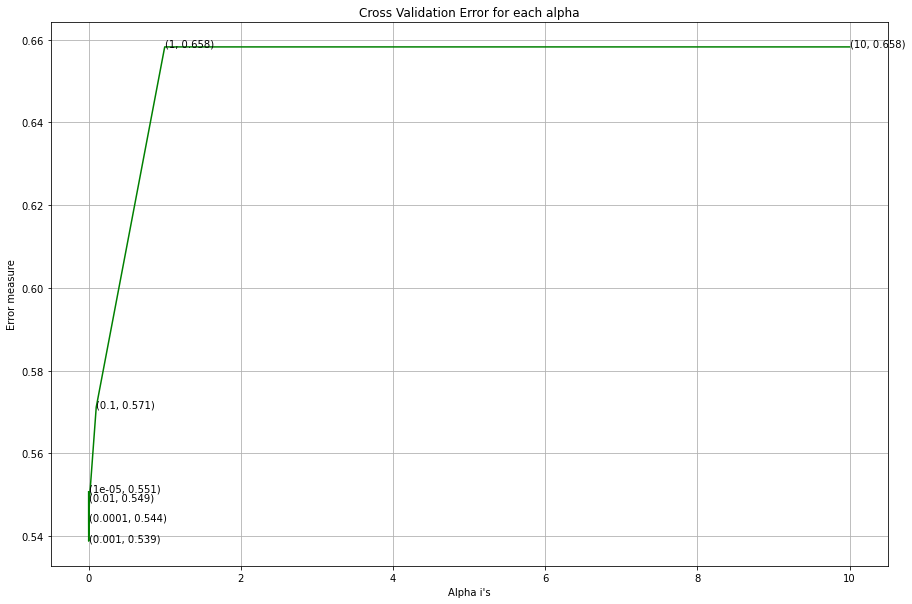

For values of best alpha =  0.001 The train log loss is: 0.5350504233108775
For values of best alpha =  0.001 The test log loss is: 0.5358836685296398
Total number of data points : 48475
--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7033
---------------------------------------------------------------------


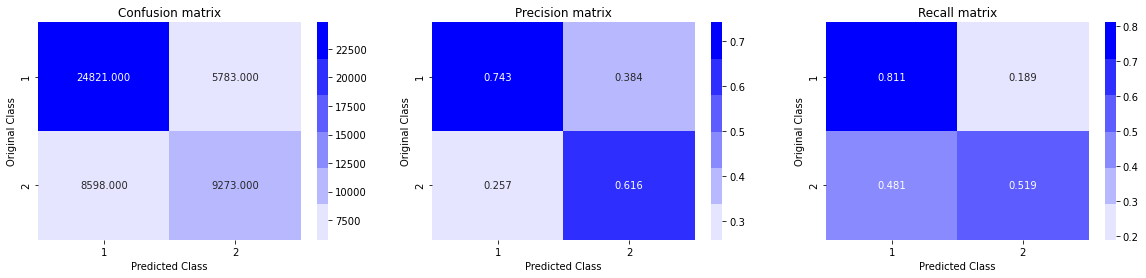

In [18]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in (alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, shuffle=True)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of best alpha =  0.001 The train log loss is: 0.5350504233108775
For values of best alpha =  0.001 The test log loss is: 0.5358836685296398
Total number of data points : 48475
--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7028
---------------------------------------------------------------------


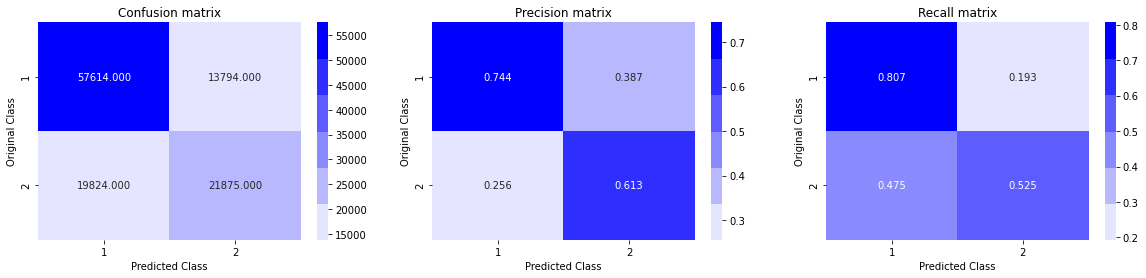

[[57614 13794]
 [19824 21875]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     71408
           1       0.61      0.52      0.57     41699

    accuracy                           0.70    113107
   macro avg       0.68      0.67      0.67    113107
weighted avg       0.70      0.70      0.70    113107



In [19]:
predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y_train =np.argmax(predict_y_train,axis=1)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

## for Train
plot_confusion_matrix(y_train, predicted_y_train)
print_report(y_train, predicted_y_train)


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7033
---------------------------------------------------------------------


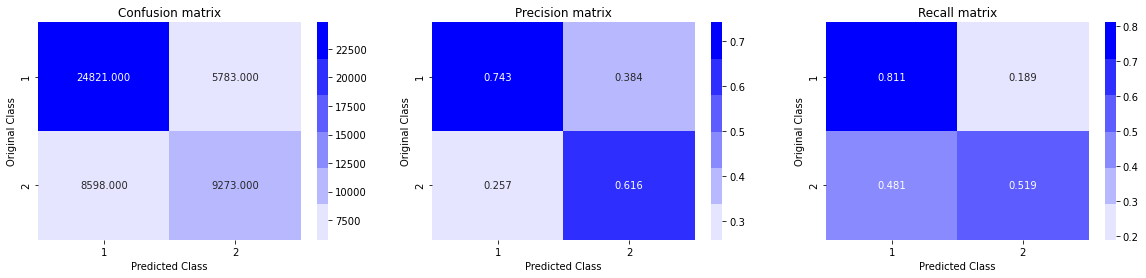

In [20]:
## For Test

plot_confusion_matrix(y_test, predicted_y)

In [21]:
print_report(y_test, predicted_y)

[[24821  5783]
 [ 8598  9273]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.78     30604
           1       0.62      0.52      0.56     17871

    accuracy                           0.70     48475
   macro avg       0.68      0.66      0.67     48475
weighted avg       0.70      0.70      0.70     48475



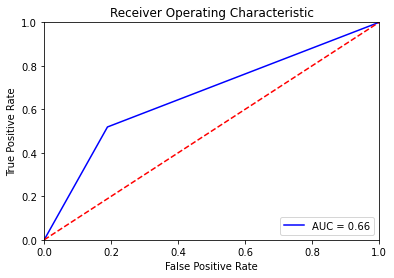

In [22]:
y_test_probs = plot_roc(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

Not used as it takes long time to run. 

In [23]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


# log_error_array=[]
# for i in alpha:
#     clf = SVC(C=i,  class_weight='balanced', verbose=True, random_state=42)
#     clf.fit(X_train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(X_train, y_train)
#     predict_y = sig_clf.predict_proba(X_test)
#     log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
#     print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()


# best_alpha = np.argmin(log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

# predict_y = sig_clf.predict_proba(X_train)
# print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(X_test)
# print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
# predicted_y =np.argmax(predict_y,axis=1)
# print("Total number of data points :", len(predicted_y))
# plot_confusion_matrix(y_test, predicted_y)

## XG Boost


In [24]:
parameters = {'nthread':4, #when use hyperthread, xgboost may become slower
              'objective':'binary:logistic',
              'learning_rate': 0.02, #so called `eta` value
              'max_depth': 6,
              'min_child_weight': 11,
              'silent': 1,
              'subsample': 0.8,
              'colsample_bytree': 0.7,
              'n_estimators': 5, #number of trees, change it to 1000 for better results
              'missing':-999,
              'seed': 1337}

In [25]:
import xgboost as xgb

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(parameters, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[09:38:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { missing, n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.29765	valid-error:0.30009
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 20 rounds.
[10]	train-error:0.28393	valid-error:0.28852
[20]	train-error:0.28066	valid-error:0.28536
[30]	train-error:0.27768	valid-error:0.28285
[40]	train-error:0.27539	valid-error:0.28264
[50]	train-error:0.27368	valid-error:0.28060
[60]	train-error:0.27146	valid-error:0.27944
[70]	train-error:0.26907	valid-error:0.27831
[80]	train-error:0.26661	valid-error:0.27627
[90]	train-error:0.26413	valid-error:0.274

--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7862
---------------------------------------------------------------------


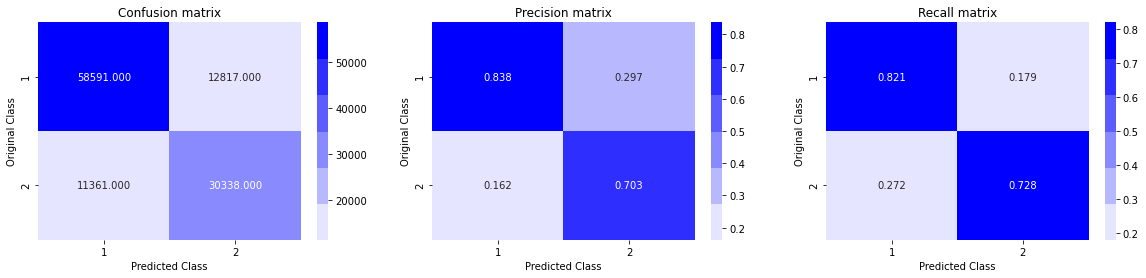

[[58591 12817]
 [11361 30338]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     71408
           1       0.70      0.73      0.72     41699

    accuracy                           0.79    113107
   macro avg       0.77      0.77      0.77    113107
weighted avg       0.79      0.79      0.79    113107



In [26]:
predict_y_train = bst.predict(d_train)
predicted_y_train =np.array(predict_y_train > 0.5,dtype=int)
plot_confusion_matrix(y_train, predicted_y_train)
print_report(y_train, predicted_y_train)

Total number of data points : 48475
--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7508
---------------------------------------------------------------------


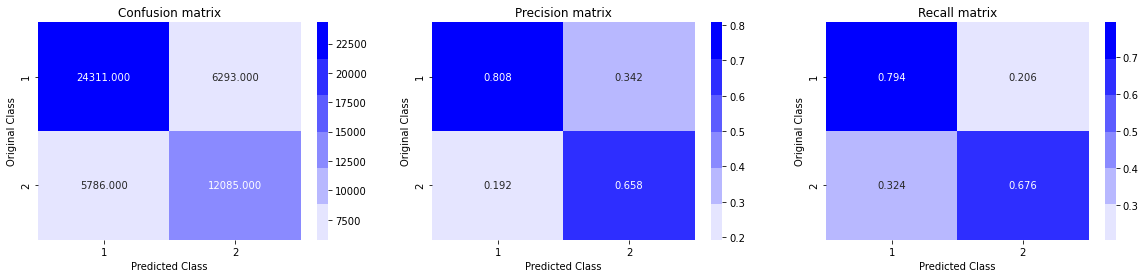

In [27]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7508
---------------------------------------------------------------------


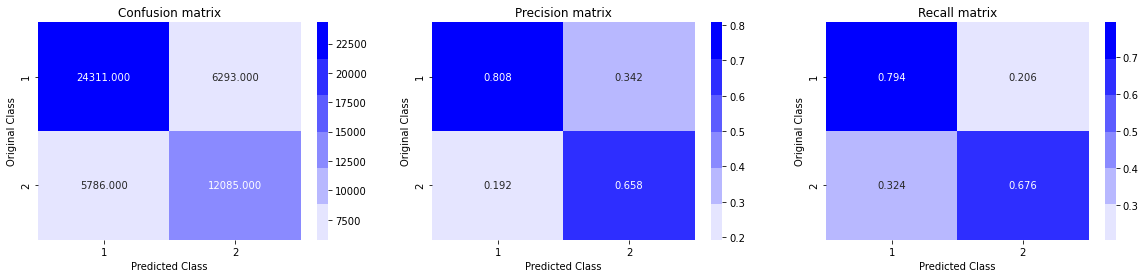

In [28]:
plot_confusion_matrix(y_test, predicted_y)

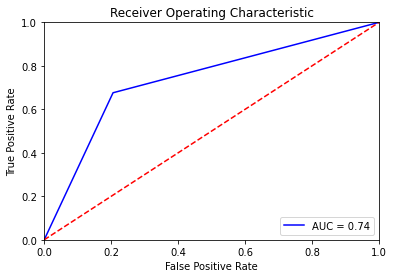

In [29]:
y_test_probs = plot_roc(y_test, predicted_y)

## Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7691
---------------------------------------------------------------------


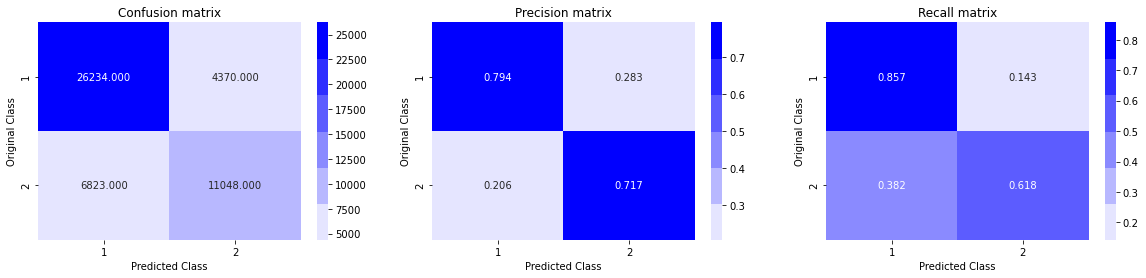

[[26234  4370]
 [ 6823 11048]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     30604
           1       0.72      0.62      0.66     17871

    accuracy                           0.77     48475
   macro avg       0.76      0.74      0.74     48475
weighted avg       0.77      0.77      0.77     48475



In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=False, max_features=25, n_estimators=50, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
predicted_y = rf.predict(X_test)


plot_confusion_matrix(y_test, predicted_y)

print_report(y_test, predicted_y)





[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.9979
---------------------------------------------------------------------


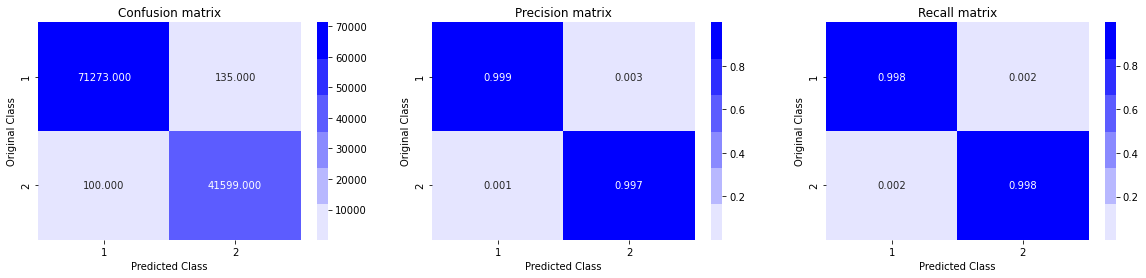

[[71273   135]
 [  100 41599]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71408
           1       1.00      1.00      1.00     41699

    accuracy                           1.00    113107
   macro avg       1.00      1.00      1.00    113107
weighted avg       1.00      1.00      1.00    113107



In [36]:
predicted_y_train = rf.predict(X_train)
plot_confusion_matrix(y_train, predicted_y_train)

print_report(y_train, predicted_y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7633
---------------------------------------------------------------------


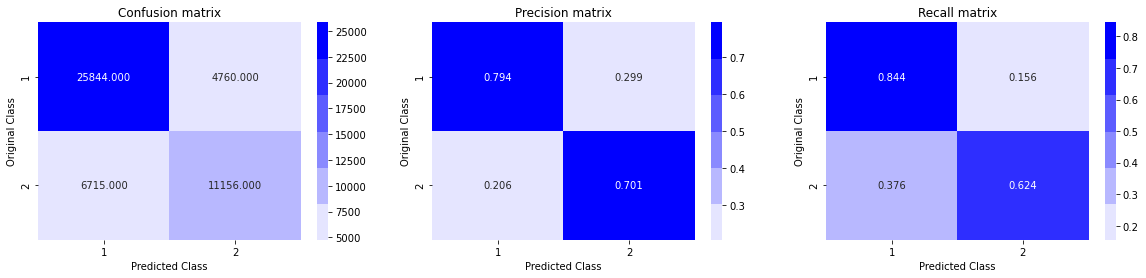

[[25844  4760]
 [ 6715 11156]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82     30604
           1       0.70      0.62      0.66     17871

    accuracy                           0.76     48475
   macro avg       0.75      0.73      0.74     48475
weighted avg       0.76      0.76      0.76     48475



In [37]:
predicted_y = rf.predict(X_test)


plot_confusion_matrix(y_test, predicted_y)

print_report(y_test, predicted_y)

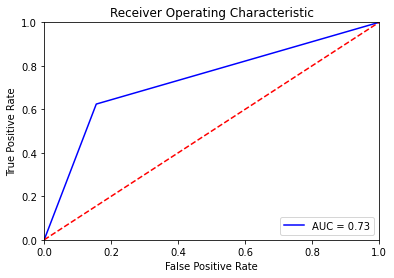

In [38]:
plot_roc(y_test, predicted_y)

In [ ]:
predict_y = sig_clf.predict_proba(X_test)
predicted_y_log =np.argmax(predict_y,axis=1)

predict_y_xg = bst.predict(d_test)
predicted_y_rf = rf.predict(X_test)
 

## Grid Search on Random Forest.

In [39]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier(n_jobs=-1, verbose=1)
param_grid = [
{'n_estimators': [10, 50], 'max_features': [25, 50], 
 'max_depth': [30, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=5)
grid_search_forest.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 o

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   5

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, verbose=1),
             param_grid=[{'bootstrap': [True, False], 'max_depth': [30, None],
                          'max_features': [25, 50], 'n_estimators': [10, 50]}])

In [45]:
#find the best model of grid search
grid_search_forest.best_estimator_

RandomForestClassifier(bootstrap=False, max_features=25, n_estimators=50,
                       n_jobs=-1, verbose=1)

In [46]:
#now let's how the RMSE changes for each parameter configuration
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)



0.7251629306107732 {'bootstrap': True, 'max_depth': 30, 'max_features': 25, 'n_estimators': 10}
0.7554528215381503 {'bootstrap': True, 'max_depth': 30, 'max_features': 25, 'n_estimators': 50}
0.7249507094786218 {'bootstrap': True, 'max_depth': 30, 'max_features': 50, 'n_estimators': 10}
0.7554174432723181 {'bootstrap': True, 'max_depth': 30, 'max_features': 50, 'n_estimators': 50}
0.7262680655455723 {'bootstrap': True, 'max_depth': None, 'max_features': 25, 'n_estimators': 10}
0.7533221057694424 {'bootstrap': True, 'max_depth': None, 'max_features': 25, 'n_estimators': 50}
0.7266570736554421 {'bootstrap': True, 'max_depth': None, 'max_features': 50, 'n_estimators': 10}
0.7560628780524297 {'bootstrap': True, 'max_depth': None, 'max_features': 50, 'n_estimators': 50}
0.7339245755820649 {'bootstrap': False, 'max_depth': 30, 'max_features': 25, 'n_estimators': 10}
0.7626495423108579 {'bootstrap': False, 'max_depth': 30, 'max_features': 25, 'n_estimators': 50}
0.7351181051782113 {'bootstrap

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.7s finished


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.998
---------------------------------------------------------------------


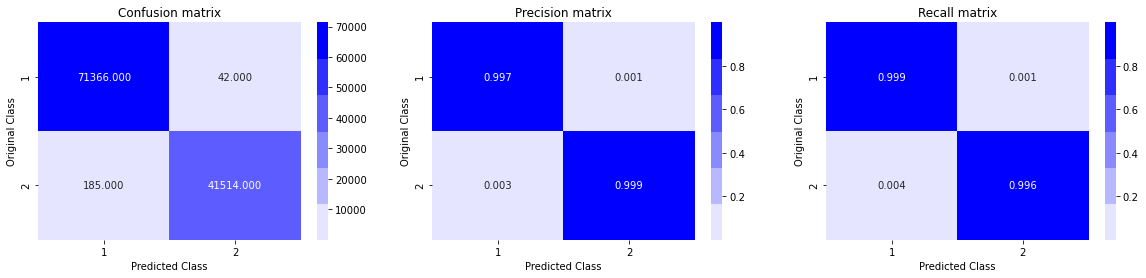

[[71366    42]
 [  185 41514]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71408
           1       1.00      1.00      1.00     41699

    accuracy                           1.00    113107
   macro avg       1.00      1.00      1.00    113107
weighted avg       1.00      1.00      1.00    113107



In [47]:
predicted_y_train = grid_search_forest.best_estimator_.predict(X_train)
plot_confusion_matrix(y_train, predicted_y_train)

print_report(y_train, predicted_y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.2s finished


--------------------       ACCUARACY SCORE       --------------------
           Accuracy score for model is :  0.7674
---------------------------------------------------------------------


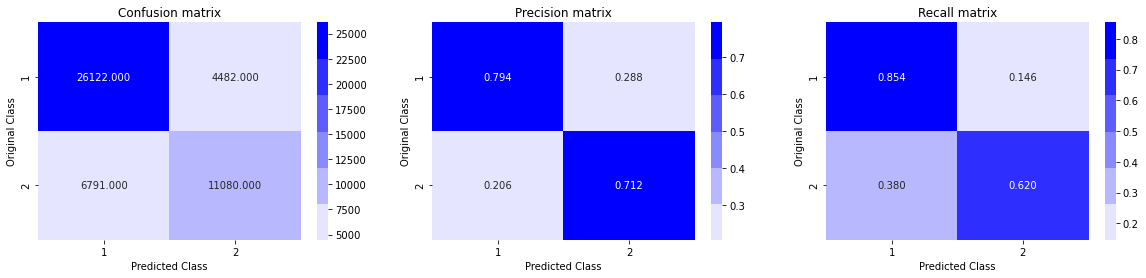

[[26122  4482]
 [ 6791 11080]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     30604
           1       0.71      0.62      0.66     17871

    accuracy                           0.77     48475
   macro avg       0.75      0.74      0.74     48475
weighted avg       0.76      0.77      0.76     48475



In [48]:
predicted_y = grid_search_forest.best_estimator_.predict(X_test)


plot_confusion_matrix(y_test, predicted_y)

print_report(y_test, predicted_y)

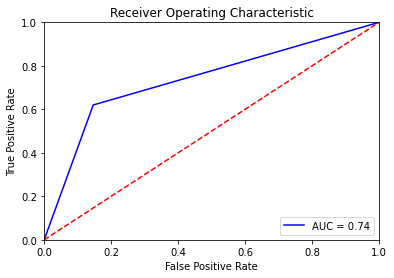

In [49]:
y_test_probs = plot_roc(y_test, predicted_y)

## Best is XGBoost